In [108]:
from robomaster import robot
import time
import threading
import copy
import pandas as pd

data_log = []
stop_event = threading.Event()
robot_graph = {
    'angle': 0,
    'tof': 0
}

def sub_data_handler(sub_info):
    # รับข้อมูลระยะทางจากเซ็นเซอร์ TOF
    robot_graph['tof'] = sub_info[0]+75

def sub_data_handler_angle(angle_info):
    # รับข้อมูลมุมจากกิมบอล
    pitch_angle, yaw_angle, pitch_ground_angle, yaw_ground_angle = angle_info
    print(f"gimbal angle: pitch_angle:{pitch_angle}, yaw_angle:{yaw_angle}, pitch_ground_angle:{pitch_ground_angle}, yaw_ground_angle:{yaw_ground_angle}")
    robot_graph['angle'] = yaw_angle

def data_logger(log_interval):
    """
    ฟังก์ชันนี้จะทำงานใน background thread
    เพื่อบันทึกสถานะของหุ่นยนต์ลง list ตามช่วงเวลาที่กำหนด
    """
    while not stop_event.is_set():
        robot_graph['timestamp'] = pd.Timestamp.now()
        current_log = copy.deepcopy(robot_graph)
        data_log.append(current_log)
        time.sleep(log_interval)
    print("Data logger thread stopped.")

#grimball to sensor 75

ep_robot = robot.Robot()
ep_robot.initialize(conn_type="ap")
ep_gimbal = ep_robot.gimbal
ep_sensor = ep_robot.sensor

log_interval = 0.02
logger_thread = threading.Thread(target=data_logger, args=(log_interval,))

# หมุนกิมบอลไปที่ yaw=90 ด้วยความเร็ว 45 องศา/วินาที
ep_gimbal.moveto(pitch=0, yaw=90, pitch_speed=45, yaw_speed=45).wait_for_completed()
logger_thread.start()
# สมัครรับข้อมูลระยะทางจากเซ็นเซอร์ TOF
ep_sensor.sub_distance(freq=20, callback=sub_data_handler)
# สมัครรับข้อมูลมุมจากกิมบอล
ep_gimbal.sub_angle(freq=20, callback=sub_data_handler_angle)

# หมุนกิมบอลไปที่ yaw=-90 ด้วยความเร็ว 45 องศา/วินาที
ep_gimbal.moveto(pitch=0, yaw=-90, pitch_speed=45, yaw_speed=45).wait_for_completed()

# หยุด data logger
stop_event.set()
logger_thread.join()

ep_robot.close()

df = pd.DataFrame(data_log)
# จัดลำดับคอลัมน์ให้สวยงาม
cols = [k for k in robot_graph.keys()]
df = df[cols]
df.to_csv("robot_full_data.csv", index=False)
print("Data saved to robot_full_data.csv successfully.")

gimbal angle: pitch_angle:-2.4, yaw_angle:90.2, pitch_ground_angle:0.0, yaw_ground_angle:98.4
gimbal angle: pitch_angle:-2.4, yaw_angle:87.9, pitch_ground_angle:0.0, yaw_ground_angle:96.3
gimbal angle: pitch_angle:-2.4, yaw_angle:84.7, pitch_ground_angle:0.0, yaw_ground_angle:93.7
gimbal angle: pitch_angle:-2.4, yaw_angle:82.8, pitch_ground_angle:0.0, yaw_ground_angle:91.9
gimbal angle: pitch_angle:-2.3, yaw_angle:80.2, pitch_ground_angle:0.0, yaw_ground_angle:89.2
gimbal angle: pitch_angle:-2.3, yaw_angle:78.4, pitch_ground_angle:0.0, yaw_ground_angle:87.4
gimbal angle: pitch_angle:-2.3, yaw_angle:75.8, pitch_ground_angle:0.0, yaw_ground_angle:84.7
gimbal angle: pitch_angle:-2.3, yaw_angle:74.1, pitch_ground_angle:0.0, yaw_ground_angle:82.9
gimbal angle: pitch_angle:-2.3, yaw_angle:71.4, pitch_ground_angle:0.0, yaw_ground_angle:80.2
gimbal angle: pitch_angle:-2.3, yaw_angle:69.6, pitch_ground_angle:0.0, yaw_ground_angle:78.4
gimbal angle: pitch_angle:-2.3, yaw_angle:66.7, pitch_ground

In [109]:
import matplotlib.pyplot as mp

Raw_data = pd.read_csv("robot_full_data.csv")
Raw_data = Raw_data[Raw_data['tof'] <= 500]
Raw_data


,angle,tof,timestamp
0,0.0,0,2025-07-15 11:18:02.578335
1,0.0,0,2025-07-15 11:18:02.601517
2,0.0,0,2025-07-15 11:18:02.633082
3,90.2,274,2025-07-15 11:18:02.664116
4,90.2,274,2025-07-15 11:18:02.695659
...,...,...,...
128,-83.9,298,2025-07-15 11:18:06.542517
129,-85.7,298,2025-07-15 11:18:06.572424
130,-88.5,296,2025-07-15 11:18:06.603288
131,-88.5,296,2025-07-15 11:18:06.633817


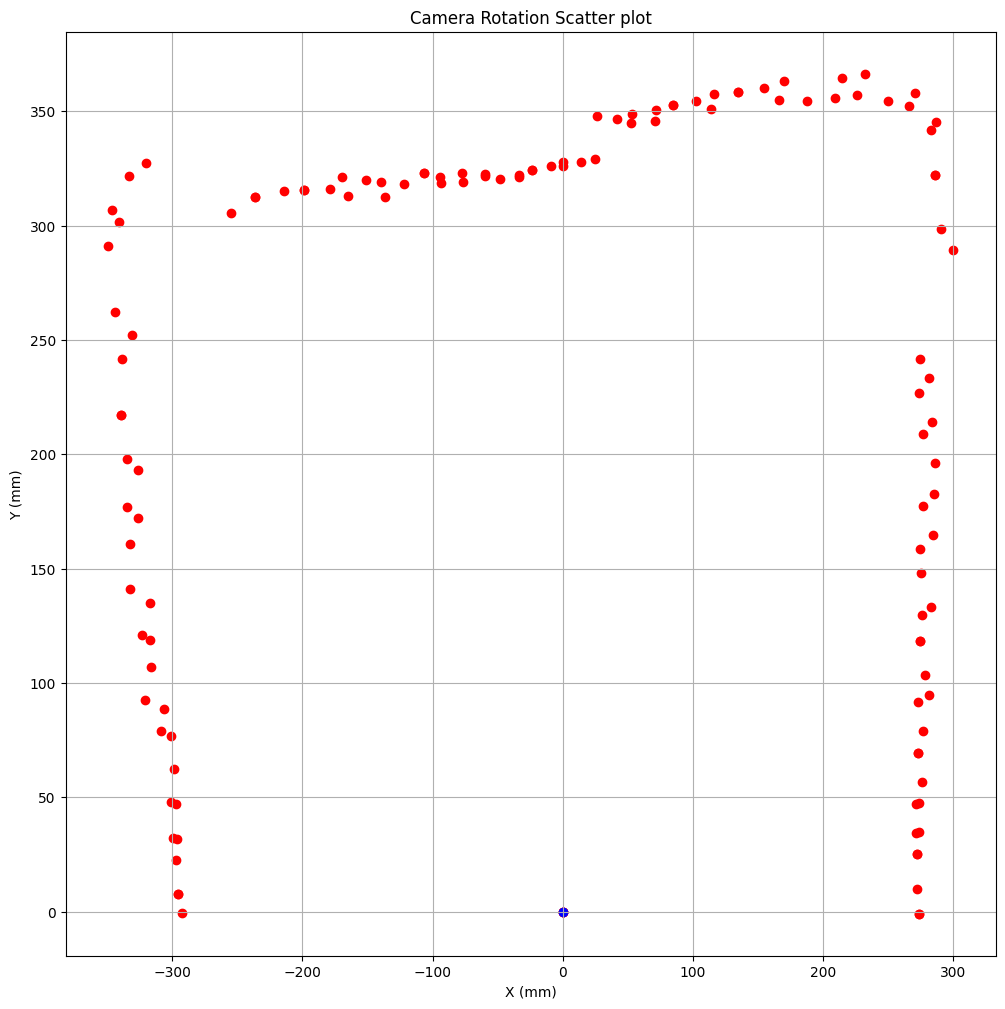

In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


angles_rad = np.deg2rad(Raw_data['angle'])
distances = (Raw_data['tof'])


u = distances * np.cos(angles_rad)
v = distances * np.sin(angles_rad)
plt.figure(figsize=(12, 12))
plt.scatter(v, u, color='red')
plt.scatter(0, 0, color='b')

plt.grid()
plt.title('Camera Rotation Scatter plot')
plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')
plt.show()